In [14]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir='/content/drive/MyDrive/ucd/'
base_dir='../../../folders/'

In [15]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, DepthwiseConv1D, GlobalAveragePooling1D, Reshape, Dropout
from tensorflow.keras.models import Model
from keras.layers import Conv1D, SeparableConv1D,GlobalAveragePooling1D,Add,concatenate, Conv2D,MaxPooling1D,MaxPooling2D, Dropout,Dense,Flatten,Activation, Flatten, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import scipy.stats as stats
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [16]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    def precision_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
with open(base_dir+f'all/train_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_train = res['x_train']
                y_train = res['y_train']
del res
x_train=np.reshape(x_train,(len(x_train),3840,1))
print(x_train.shape)
print(y_train.shape)

(49797, 3840, 1)
(49797, 4)


In [18]:
with open(base_dir+f'all/test_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_test = res['x_test']
                y_test = res['y_test']
del res
x_test=np.reshape(x_test,(len(x_test),3840,1))
print(x_test.shape)
print(y_test.shape)

(12450, 3840, 1)
(12450, 4)


In [19]:

def build_efficientnet_b2(input_shape, num_classes):
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    # Initial Stem
    model.add(Conv1D(filters=32, kernel_size=3, strides=2, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('swish'))  # Swish activation function

    # Depthwise Separable Convolution Blocks
    block_settings = [
        {'repeats': 1, 'filters_in': 32, 'filters_out': 16, 'kernel_size': 3, 'strides': 1},
        {'repeats': 2, 'filters_in': 16, 'filters_out': 24, 'kernel_size': 3, 'strides': 2},
        {'repeats': 2, 'filters_in': 24, 'filters_out': 40, 'kernel_size': 3, 'strides': 2},
    ]

    for settings in block_settings:
        for _ in range(settings['repeats']):
            model.add(DepthwiseConv1D(kernel_size=settings['kernel_size'], strides=settings['strides'], padding='same'))
            model.add(BatchNormalization())
            model.add(Activation('swish'))  # Swish activation function
            model.add(Conv1D(filters=settings['filters_out'], kernel_size=1, padding='same'))
            model.add(BatchNormalization())
            model.add(Activation('swish'))  # Swish activation function

    # Global Average Pooling and Classifier
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax'))

    return model

input_shape = (3840,1)
num_classes = 4 
model = build_efficientnet_b2(input_shape, num_classes)
model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  (None, 3840, 1)          4         
 chNormalization)                                                
                                                                 
 conv1d_6 (Conv1D)           (None, 1920, 32)          128       
                                                                 
 batch_normalization_13 (Bat  (None, 1920, 32)         128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 1920, 32)          0         
                                                                 
 depthwise_conv1d_5 (Depthwi  (None, 1920, 32)         128       
 seConv1D)                                                       
                                                      

In [20]:
checkpoint = ModelCheckpoint(base_dir+"models/efficientnet.keras")
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy',f1])
history=model.fit(x_train,y_train,batch_size=256,epochs=250,callbacks=[checkpoint], validation_split=0.10)

Epoch 1/250
176/176 [==============================] - 13s 66ms/step - loss: 1.1967 - accuracy: 0.5150 - f1: 0.3813 - val_loss: 1.2742 - val_accuracy: 0.5040 - val_f1: 0.0000e+00
Epoch 2/250
176/176 [==============================] - 11s 64ms/step - loss: 1.0763 - accuracy: 0.5511 - f1: 0.4755 - val_loss: 1.3787 - val_accuracy: 0.2209 - val_f1: 0.0000e+00
Epoch 3/250
176/176 [==============================] - 11s 64ms/step - loss: 1.0286 - accuracy: 0.5692 - f1: 0.4997 - val_loss: 1.3725 - val_accuracy: 0.3944 - val_f1: 0.2336
Epoch 4/250
176/176 [==============================] - 11s 64ms/step - loss: 0.9892 - accuracy: 0.5884 - f1: 0.5329 - val_loss: 1.1573 - val_accuracy: 0.5500 - val_f1: 0.5333
Epoch 5/250
176/176 [==============================] - 11s 65ms/step - loss: 0.9549 - accuracy: 0.6053 - f1: 0.5627 - val_loss: 1.1494 - val_accuracy: 0.5701 - val_f1: 0.5575
Epoch 6/250
176/176 [==============================] - 11s 64ms/step - loss: 0.9222 - accuracy: 0.6232 - f1: 0.5846 -

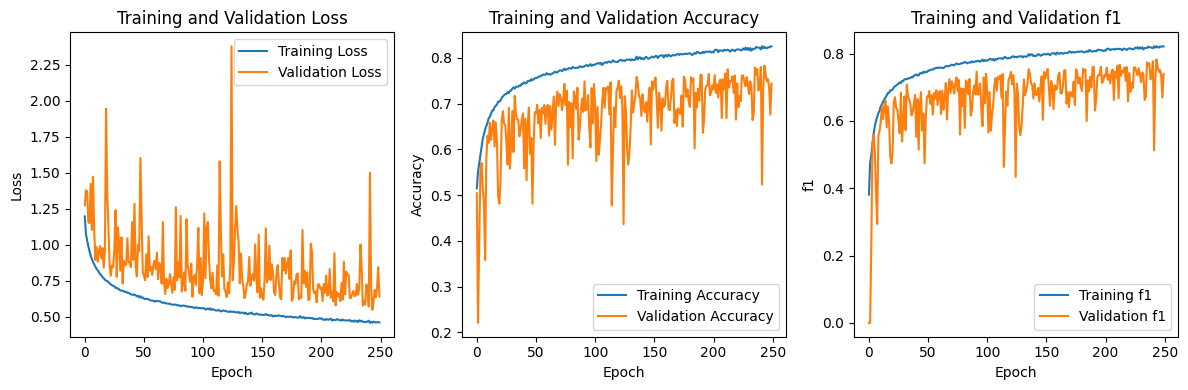

In [21]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot F1
plt.subplot(1, 3, 3)
plt.plot(history.history['f1'], label='Training f1')
plt.plot(history.history['val_f1'], label='Validation f1')
plt.title('Training and Validation f1')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
del x_train
del y_train

In [23]:
# model=load_model(base_dir+"models/efficientnet.keras",custom_objects={'f1':f1})
# model.summary()

In [24]:
y_pred=model.predict(x_test,batch_size=256)
y_pred = to_categorical(np.argmax(y_pred, axis=1), 4).astype(int)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

49/49 [==============================] - 1s 13ms/step


In [25]:
print(classification_report(y_test,y_pred,target_names=['WAKE','REM','LIGHT','DEEP']))

              precision    recall  f1-score   support

        WAKE       0.73      0.76      0.74      2810
         REM       0.73      0.70      0.71      1809
       LIGHT       0.79      0.78      0.78      6233
        DEEP       0.69      0.70      0.70      1598

    accuracy                           0.75     12450
   macro avg       0.73      0.74      0.73     12450
weighted avg       0.75      0.75      0.75     12450



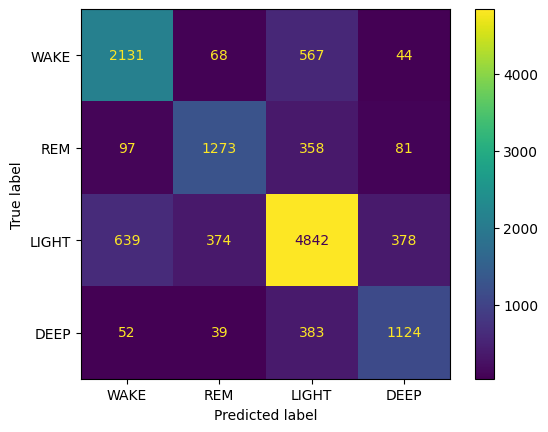

In [26]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['WAKE','REM','LIGHT','DEEP'])
disp.plot()
plt.show()